# Imports

In [1]:
import os
import torchvision
from torchvision import models,transforms,datasets
import torch.nn as nn
import time

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch
import bcolz
%matplotlib inline

In [ ]:
!pip install bcolz

In [2]:
import imp
import utils; imp.reload(utils)
from utils import *

GPU test

In [3]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

Using gpu: True 


In [ ]:
use_gpu =  False

# Data process

In [4]:
# data_dir = 'D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_Food101\\images'
data_dir = '/home/foodlovers/FoodVisor/data/images'
# data_dir = "/home/foodlovers/FoodVisor/FoodVisor-TMM/data/UPMC_2"

In [5]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep2)
         for x in ['train', 'test']}

In [ ]:
len(dsets['train'].classes)

In [ ]:
dsets['train'].class_to_idx

In [ ]:
dsets['train'].imgs[:5]

In [6]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_sizes

{'train': 67988, 'test': 22716}

In [92]:
from collections import Counter
class_counts_train = dict(Counter(sample_tup[1] for sample_tup in dsets['train'].imgs))
class_counts_train

{0: 701,
 1: 662,
 2: 676,
 3: 664,
 4: 672,
 5: 671,
 6: 669,
 7: 673,
 8: 677,
 9: 642,
 10: 692,
 11: 679,
 12: 689,
 13: 659,
 14: 693,
 15: 678,
 16: 672,
 17: 696,
 18: 665,
 19: 659,
 20: 655,
 21: 694,
 22: 672,
 23: 688,
 24: 669,
 25: 658,
 26: 661,
 27: 674,
 28: 672,
 29: 682,
 30: 685,
 31: 693,
 32: 682,
 33: 690,
 34: 638,
 35: 603,
 36: 684,
 37: 636,
 38: 624,
 39: 645,
 40: 634,
 41: 668,
 42: 711,
 43: 633,
 44: 685,
 45: 698,
 46: 669,
 47: 699,
 48: 667,
 49: 685,
 50: 675,
 51: 684,
 52: 696,
 53: 698,
 54: 608,
 55: 701,
 56: 669,
 57: 701,
 58: 694,
 59: 696,
 60: 591,
 61: 645,
 62: 713,
 63: 690,
 64: 678,
 65: 700,
 66: 672,
 67: 691,
 68: 650,
 69: 667,
 70: 690,
 71: 684,
 72: 701,
 73: 672,
 74: 630,
 75: 652,
 76: 702,
 77: 678,
 78: 630,
 79: 658,
 80: 669,
 81: 695,
 82: 705,
 83: 679,
 84: 708,
 85: 643,
 86: 677,
 87: 682,
 88: 655,
 89: 681,
 90: 638,
 91: 651,
 92: 688,
 93: 686,
 94: 669,
 95: 710,
 96: 696,
 97: 668,
 98: 695,
 99: 631,
 100: 703}

Dataset loaders

In [7]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=32,
                                               shuffle=shuffle_valtrain(x), num_workers=6)
                for x in ['train', 'test']}

In [ ]:
len(dset_loaders['train'])

In [ ]:
dataset_valid = torch.utils.data.DataLoader(dsets['test'], batch_size=5, shuffle=True, num_workers=6)

In [ ]:
len(dataset_valid)

In [ ]:
count = 0
for data in dataset_valid:
    if count == 0:
        inputs_try,labels_try = data
    else:
        break
    count += 1

In [ ]:
labels_try

In [ ]:
inputs_try.shape

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [ ]:
# Get a batch of validation data
inputs, classes = next(iter(dset_loaders['test']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

# Creating InceptionV3 Model

In [6]:
model_inception = models.inception_v3(pretrained=True)

In [ ]:
if use_gpu:
    model_inception = model_inception.cuda()
    
inputs_try , labels_try = var_cgpu(inputs_try,use_gpu),var_cgpu(labels_try,use_gpu)

In [ ]:
outputs_try,__ = model_inception(inputs_try)

In [ ]:
inputs_try.shape

In [ ]:
outputs_try

In [ ]:
outputs_try.shape

### Modifying the last layer and setting the gradient false to all layers

In [6]:
print(model_inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [ ]:
for param in model_inception.parameters():
    param.requires_grad = False

In [7]:
model_inception.fc = nn.Linear(2048, 101)

In [8]:
model_inception.AuxLogits.fc = nn.Linear(768, 101)

In [ ]:
print(model_inception.fc)

In [9]:
if use_gpu:
    model_inception = model_inception.cuda()

## Training fully connected module

### Creating loss function and optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_incep = torch.optim.SGD(model_inception.parameters(),lr = lr, momentum=0.9)

### Training the model

In [4]:
path_save_1 = '/home/foodlovers/FoodVisor/FoodVisor-TMM/trained_models/InceptionV3/model_best_2.pt'
path_save_2 = '/home/foodlovers/FoodVisor/FoodVisor-TMM/trained_models/InceptionV3/model_current_2.pt'

def train_model(epochs = 1,train = True, validate = False) :
    
    if train == True :
        loss_history = []
        acc_history = []
        val_loss_history = []
        val_acc_history = []
        
    for epoch in range(epochs) :
        if train == True :
            #=========================TRAINING=================================#
            start_time_epoch = time.time()
            
            model_inception.train()
    
            print("Epoch:", epoch,"/",epochs,"===============================================")
        
            running_loss = 0.0
            running_corrects = 0.0


            for i, data in enumerate(dset_loaders['train'], 0):
                start_time = time.time()

                # get the inputs
                inputs, classes = data

                if use_gpu:
                    inputs , classes = inputs.cuda(), classes.cuda()

                # calulate outputs and losses
                outputs, aux_outputs = model_inception(inputs)
                loss = criterion(outputs,classes) + 0.4*criterion(aux_outputs,classes)         

                # autograd
                optimizer_incep.zero_grad()
                loss.backward()
                optimizer_incep.step()

                # statistics
                batch_loss = loss.data.item()
                _,preds = torch.max(outputs.data,1)
                batch_corrects = torch.sum(preds == classes.data)
                running_loss += batch_loss
                running_corrects += batch_corrects

                print('Batch {:d}/{:d} - Loss: {:.4f} Acc: {:.4f} - Time : {:.2f}s'.format(i+1,len(dset_loaders['train']),
                             batch_loss/len(classes), float(batch_corrects)/len(classes), time.time() - start_time), end="\r")

            epoch_loss = running_loss / dset_sizes['train']
            epoch_acc = running_corrects.data.item() / dset_sizes['train']
            
            loss_history.append(epoch_loss)
            acc_history.append(epoch_acc)
            
            print('Epoch {:d} completed in {:.2f} seconds ! Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch, time.time() - start_time_epoch, epoch_loss, epoch_acc))
            
            torch.save(model_inception.state_dict(), path_save_2)
            
        if validate == True :
            #=========================VALIDATING=================================#
            
            model_inception.eval()
            
            val_loss = 0.0
            val_corrects = 0.0
            
            total = 0

            for i, data in enumerate(dset_loaders['test'], 0):
                start_time = time.time()
                
                # get the inputs
                inputs, classes = data

                if use_gpu:
                    inputs , classes = inputs.cuda(), classes.cuda()

                outputs = model_inception(inputs)

                loss = criterion(outputs,classes)        

                _,preds = torch.max(outputs.data,1)

                # statistics

                val_loss += loss.data.item()
                val_corrects += torch.sum(preds == classes.data)
                total += classes.size(0)
                
                print('Validating batch {:d}/{:d} - {:.2f}s ...'.format(i+1,len(dset_loaders['test'])
                                                                , time.time() - start_time), end="\r")

            val_epoch_loss = val_loss / dset_sizes['test']
            val_epoch_acc = val_corrects.data.item() / dset_sizes['test']

            print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(
                             val_epoch_loss,val_epoch_acc))
            
            if train == False :
                return
            else :
                if len(val_acc_history) == 0 or val_epoch_acc >= max(val_acc_history) :
                    torch.save(model_inception.state_dict(), path_save_1)
                
                val_loss_history.append(val_epoch_loss)
                val_acc_history.append(val_epoch_acc)
    
    if train == False :
        return 'On fait rien!'
    elif validate == False :
        return loss_history, acc_history
    else :
        return loss_history, acc_history,val_loss_history,val_acc_history

In [14]:
train_model(train=True,validate=True,epochs = 15)

Epoch: 0 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 0 completed in 2521.16 seconds ! Loss: 0.1224 Acc: 0.3394
Val Loss: 0.0732 Val Acc: 0.4549 ...
Epoch: 1 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 1 completed in 2526.47 seconds ! Loss: 0.0915 Acc: 0.4945
Val Loss: 0.0719 Val Acc: 0.4576 ...
Epoch: 2 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 2 completed in 2526.48 seconds ! Loss: 0.0763 Acc: 0.5691
Val Loss: 0.0628 Val Acc: 0.5349 ...
Epoch: 3 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 3 completed in 2526.31 seconds ! Loss: 0.0648 Acc: 0.6249
Val Loss: 0.0639 Val Acc: 0.5314 ...
Epoch: 4 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 4 completed in 2522.59 seconds ! Loss: 0.0549 Acc: 0.6760
Val Loss: 0.0619 Val Acc: 0.5581 ...
Epoch: 5 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 5 completed in 2502.38 seconds ! Loss: 0.0466 Acc: 0.7152
Val Loss: 0.0638 Val Acc: 0.5561 ...
Epoch: 6 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 6 completed in 2504.02 seconds ! Loss: 0.0392 Acc: 0.7521
Val Loss: 0.0651 Val Acc: 0.5637 ...
Epoch: 7 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 7 completed in 2502.24 seconds ! Loss: 0.0333 Acc: 0.7811
Val Loss: 0.0664 Val Acc: 0.5573 ...
Epoch: 8 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 8 completed in 2501.00 seconds ! Loss: 0.0274 Acc: 0.8165
Val Loss: 0.0711 Val Acc: 0.5578 ...
Epoch: 9 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

KeyboardInterrupt: 

### Save model weights

In [15]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_inception.state_dict():
    print(param_tensor, "\t", model_inception.state_dict()[param_tensor].size())

Model's state_dict:
Conv2d_1a_3x3.conv.weight 	 torch.Size([32, 3, 3, 3])
Conv2d_1a_3x3.bn.weight 	 torch.Size([32])
Conv2d_1a_3x3.bn.bias 	 torch.Size([32])
Conv2d_1a_3x3.bn.running_mean 	 torch.Size([32])
Conv2d_1a_3x3.bn.running_var 	 torch.Size([32])
Conv2d_1a_3x3.bn.num_batches_tracked 	 torch.Size([])
Conv2d_2a_3x3.conv.weight 	 torch.Size([32, 32, 3, 3])
Conv2d_2a_3x3.bn.weight 	 torch.Size([32])
Conv2d_2a_3x3.bn.bias 	 torch.Size([32])
Conv2d_2a_3x3.bn.running_mean 	 torch.Size([32])
Conv2d_2a_3x3.bn.running_var 	 torch.Size([32])
Conv2d_2a_3x3.bn.num_batches_tracked 	 torch.Size([])
Conv2d_2b_3x3.conv.weight 	 torch.Size([64, 32, 3, 3])
Conv2d_2b_3x3.bn.weight 	 torch.Size([64])
Conv2d_2b_3x3.bn.bias 	 torch.Size([64])
Conv2d_2b_3x3.bn.running_mean 	 torch.Size([64])
Conv2d_2b_3x3.bn.running_var 	 torch.Size([64])
Conv2d_2b_3x3.bn.num_batches_tracked 	 torch.Size([])
Conv2d_3b_1x1.conv.weight 	 torch.Size([80, 64, 1, 1])
Conv2d_3b_1x1.bn.weight 	 torch.Size([80])
Conv2d_3b_1x1

Mixed_6d.branch7x7dbl_2.bn.running_var 	 torch.Size([160])
Mixed_6d.branch7x7dbl_2.bn.num_batches_tracked 	 torch.Size([])
Mixed_6d.branch7x7dbl_3.conv.weight 	 torch.Size([160, 160, 1, 7])
Mixed_6d.branch7x7dbl_3.bn.weight 	 torch.Size([160])
Mixed_6d.branch7x7dbl_3.bn.bias 	 torch.Size([160])
Mixed_6d.branch7x7dbl_3.bn.running_mean 	 torch.Size([160])
Mixed_6d.branch7x7dbl_3.bn.running_var 	 torch.Size([160])
Mixed_6d.branch7x7dbl_3.bn.num_batches_tracked 	 torch.Size([])
Mixed_6d.branch7x7dbl_4.conv.weight 	 torch.Size([160, 160, 7, 1])
Mixed_6d.branch7x7dbl_4.bn.weight 	 torch.Size([160])
Mixed_6d.branch7x7dbl_4.bn.bias 	 torch.Size([160])
Mixed_6d.branch7x7dbl_4.bn.running_mean 	 torch.Size([160])
Mixed_6d.branch7x7dbl_4.bn.running_var 	 torch.Size([160])
Mixed_6d.branch7x7dbl_4.bn.num_batches_tracked 	 torch.Size([])
Mixed_6d.branch7x7dbl_5.conv.weight 	 torch.Size([192, 160, 1, 7])
Mixed_6d.branch7x7dbl_5.bn.weight 	 torch.Size([192])
Mixed_6d.branch7x7dbl_5.bn.bias 	 torch.Size

Mixed_7c.branch3x3dbl_3b.bn.bias 	 torch.Size([384])
Mixed_7c.branch3x3dbl_3b.bn.running_mean 	 torch.Size([384])
Mixed_7c.branch3x3dbl_3b.bn.running_var 	 torch.Size([384])
Mixed_7c.branch3x3dbl_3b.bn.num_batches_tracked 	 torch.Size([])
Mixed_7c.branch_pool.conv.weight 	 torch.Size([192, 2048, 1, 1])
Mixed_7c.branch_pool.bn.weight 	 torch.Size([192])
Mixed_7c.branch_pool.bn.bias 	 torch.Size([192])
Mixed_7c.branch_pool.bn.running_mean 	 torch.Size([192])
Mixed_7c.branch_pool.bn.running_var 	 torch.Size([192])
Mixed_7c.branch_pool.bn.num_batches_tracked 	 torch.Size([])
fc.weight 	 torch.Size([101, 2048])
fc.bias 	 torch.Size([101])


In [18]:
path_save = '/home/foodlovers/FoodVisor/FoodVisor-TMM/trained_models/InceptionV3/model_9_epoch.pt'
print("Saving model to",path_save,"...")
torch.save(model_inception.state_dict(), path_save)
print("Done !")

Saving model to /home/foodlovers/FoodVisor/trained_models/InceptionV3/model_9_epoch.pt ...
Done !


### Load model weights

In [16]:
print("Loading model from",path_save,"...")
path_save = '/home/foodlovers/FoodVisor/FoodVisor-TMM/trained_models/InceptionV3/model_9_epoch.pt'
model_inception.load_state_dict(torch.load(path_save))
print("Done !")

### Validation

In [18]:
train_model(train=False,validate=True)

Val Loss: 0.0696 Val Acc: 0.5805 ...


### Plot loss & accuracy history
I forgot to return the history, so I do it by hand ...

In [19]:
history=[[0.1224 ,0.0915 ,0.0763 ,0.0648 ,0.0549 ,0.0466 ,0.0392 ,0.0333 ,0.0274 ],
[0.3394,0.4945,0.5691,0.6249,0.6760,0.7152,0.7521,0.7811,0.8165],
[0.0732 ,0.0719 ,0.0628 ,0.0639 ,0.0619 ,0.0638 ,0.0651 ,0.0664 ,0.0711 ],
[0.4549 ,0.4576 ,0.5349 ,0.5314 ,0.5581 ,0.5561 ,0.5637 ,0.5573 ,0.5578 ]]

Text(0.5, 1.0, 'Loss history')

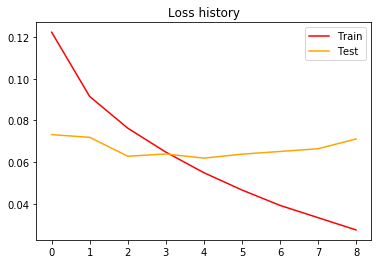

In [21]:
plt.plot(history[0],color='red',label='Train')
plt.plot(history[2],color='orange',label='Test')
plt.legend()
plt.plot()
plt.title("Loss history")

Text(0.5, 1.0, 'Training accuracy history')

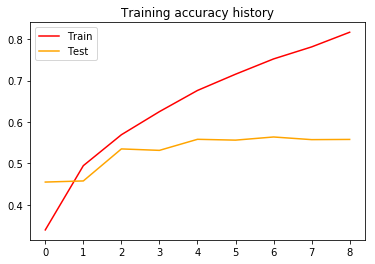

In [22]:
plt.plot(history[1],color='red',label='Train')
plt.plot(history[3],color='orange',label='Test')
plt.legend()
plt.plot()
plt.title("Training accuracy history")

### Confusion Matrix

In [43]:
import sklearn.metrics

num_classes = len(dsets['train'].classes)
confu_matrix = np.zeros((num_classes,num_classes))

for i, data in enumerate(dset_loaders['test'], 0):
    start_time = time.time()
                
    # get the inputs
    inputs, classes = data

    if use_gpu:
        inputs , classes = inputs.cuda(), classes.cuda()

    outputs = model_inception(inputs)

    _,preds = torch.max(outputs.data,1)
    
    confu_matrix += sklearn.metrics.confusion_matrix(classes.cpu(), preds.cpu(),labels=range(num_classes))
    
    print(i+1,"/",len(dset_loaders['test']),"batches processed",end="\r")


In [37]:
dsets['train'].class_to_idx

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

### Plot the confusion matrix

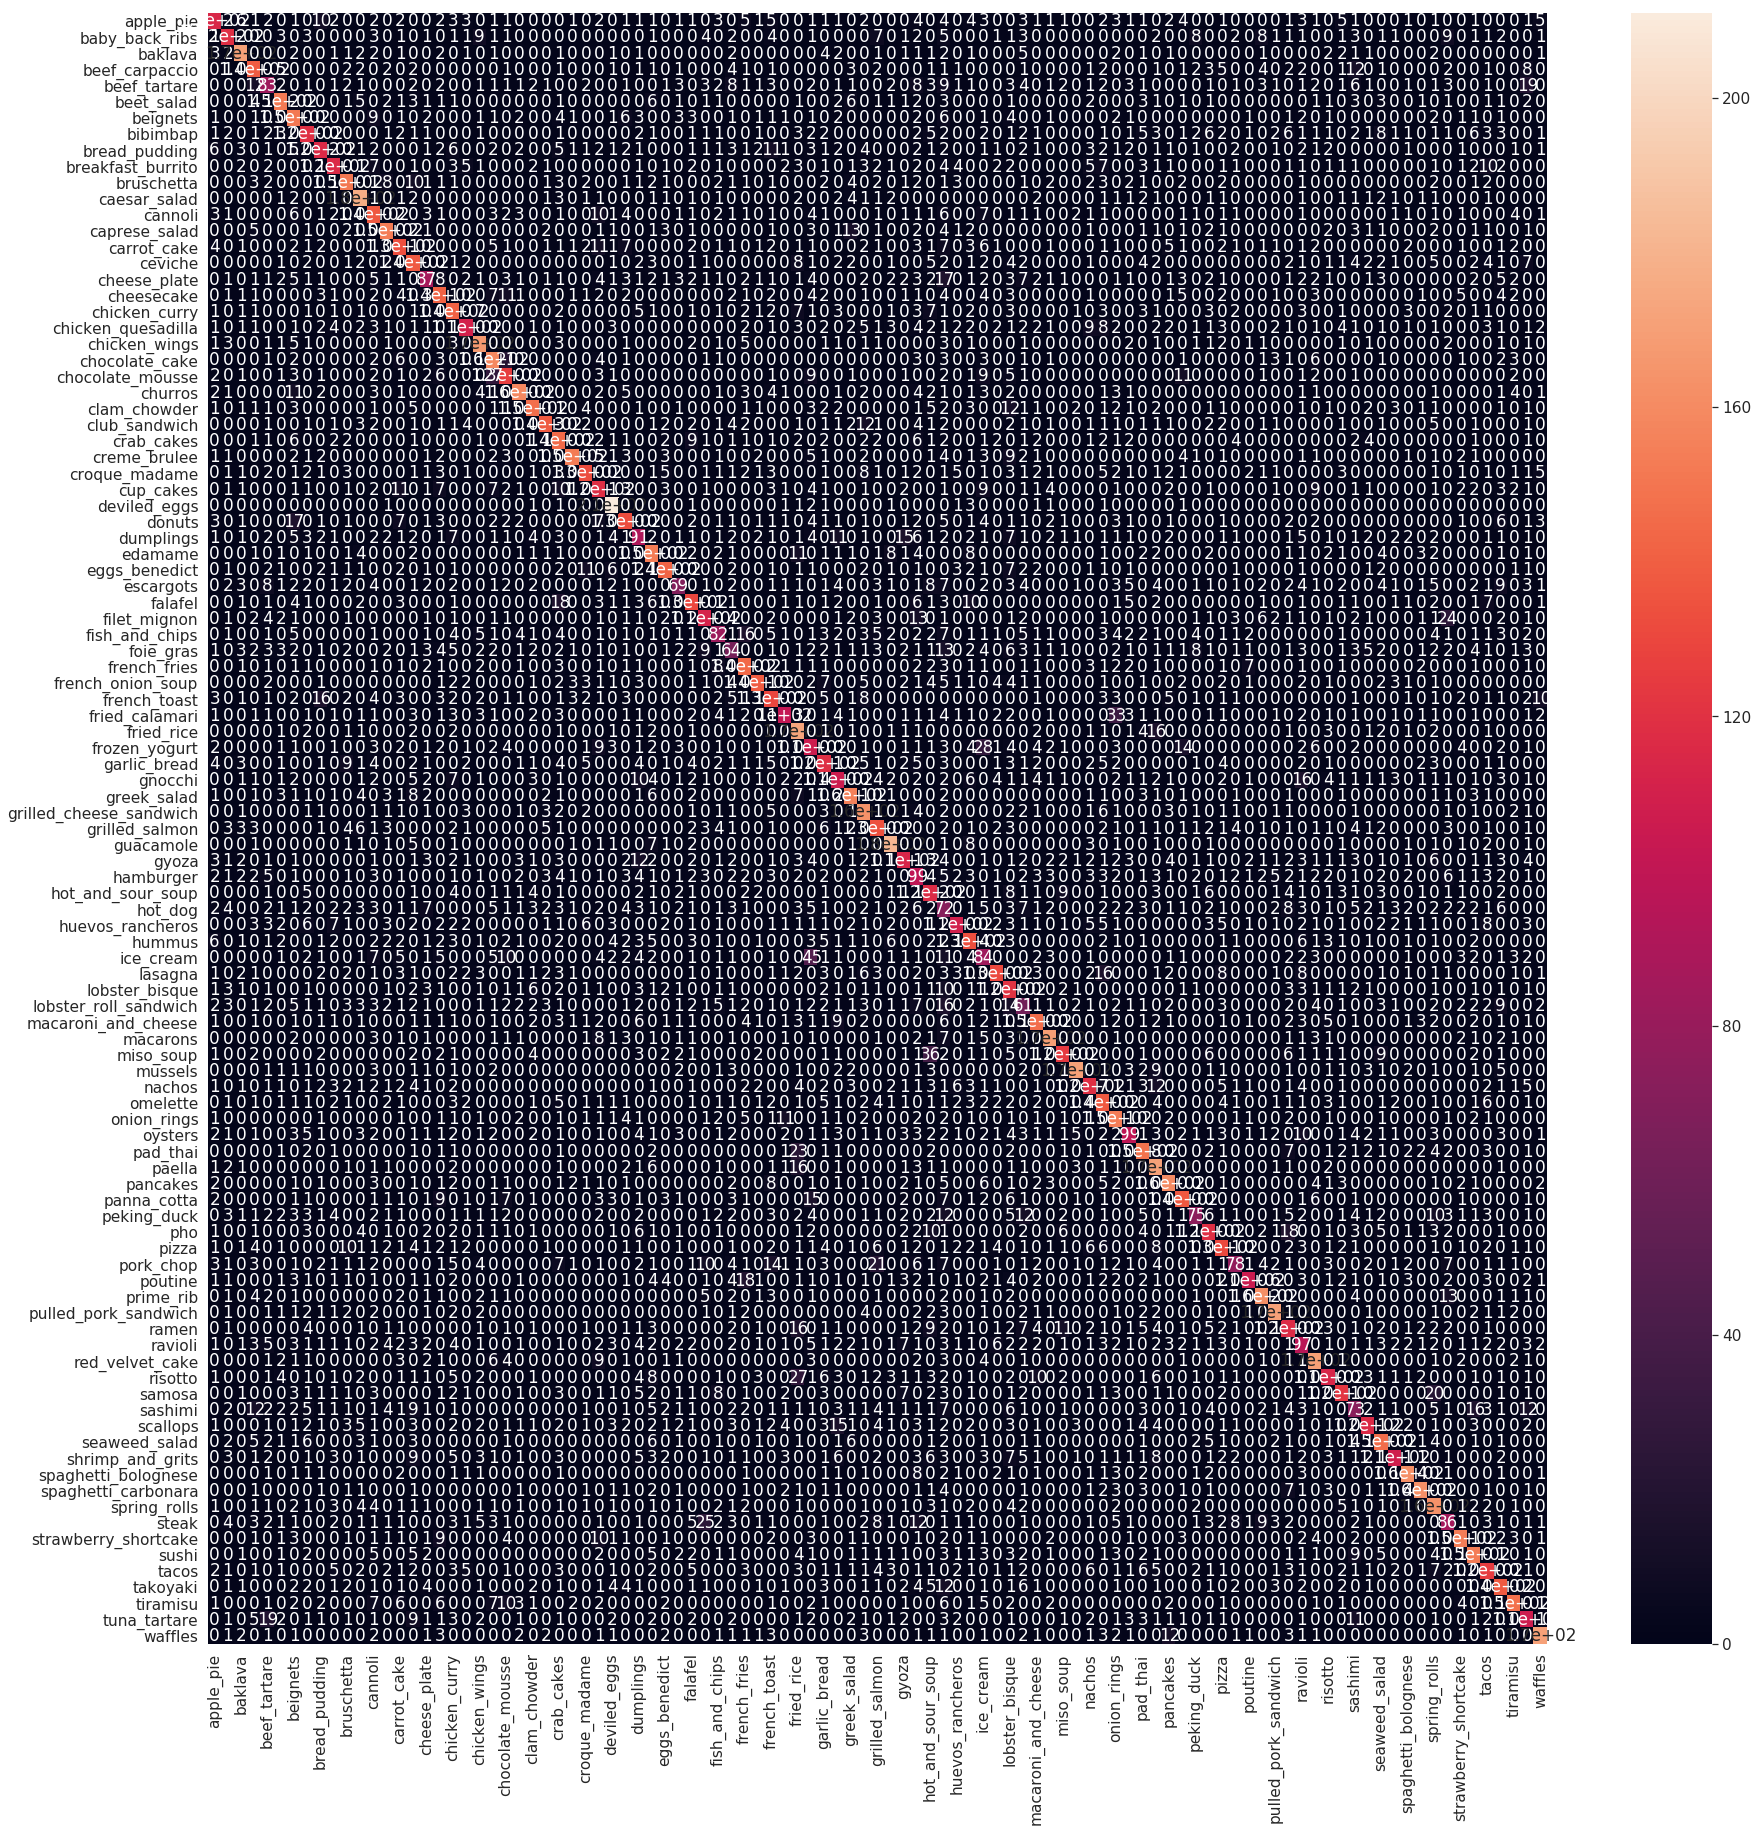

In [48]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(confu_matrix, dsets['train'].classes,
                  dsets['train'].classes)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)
#plt.figure(figsize = (10,7))
#sn.set(font_scale=1.4)#for label size
#sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

We almost cannot see anything clear... Let's try another way to analyse this

### Calculate the accuracy in each class

In [49]:
acc_dict = {}

for food in dsets['train'].class_to_idx :
    idx = dsets['train'].class_to_idx[food]
    acc_dict[food] = float(confu_matrix[idx][idx])/np.sum(confu_matrix[idx])

Let's print this in order 

In [71]:
acc_sorted = []
for key, value in sorted(acc_dict.items(), key=lambda kv: kv[1],reverse = True):
    acc_sorted.append([key, value])
    print("%s: %s" % (key, value))

deviled_eggs: 0.9213973799126638
guacamole: 0.7982456140350878
caesar_salad: 0.7797356828193832
spaghetti_bolognese: 0.7652582159624414
pulled_pork_sandwich: 0.7633928571428571
chicken_wings: 0.7625570776255708
baklava: 0.7566371681415929
fried_rice: 0.7554585152838428
paella: 0.75
red_velvet_cake: 0.748898678414097
spaghetti_carbonara: 0.7477064220183486
prime_rib: 0.7363636363636363
macarons: 0.7316017316017316
mussels: 0.7307692307692307
waffles: 0.7276595744680852
grilled_cheese_sandwich: 0.7161572052401747
spring_rolls: 0.7130434782608696
onion_rings: 0.7096774193548387
caprese_salad: 0.6954545454545454
greek_salad: 0.695067264573991
churros: 0.691304347826087
strawberry_shortcake: 0.6905829596412556
chocolate_cake: 0.6853448275862069
french_fries: 0.6839622641509434
pancakes: 0.6837606837606838
creme_brulee: 0.68
beet_salad: 0.6785714285714286
beignets: 0.6741071428571429
eggs_benedict: 0.6666666666666666
seaweed_salad: 0.6666666666666666
edamame: 0.6623376623376623
clam_chowder:

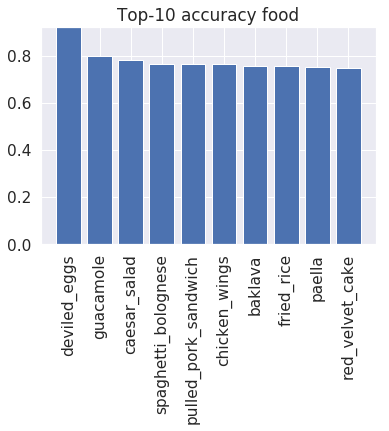

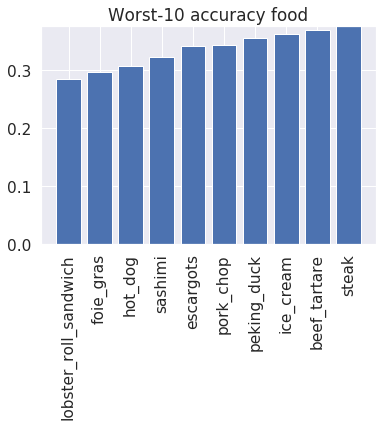

In [91]:
foods = [x[0] for x in acc_sorted]
accs = [x[1] for x in acc_sorted]

plt.bar(range(10), accs[:10], align = 'center')
plt.xticks(range(10), foods[:10], rotation='vertical')
plt.margins(0.05, 0)
plt.title("Top-10 accuracy food")

plt.figure()
plt.bar(range(10), accs[-10:][::-1], align = 'center')
plt.xticks(range(10), foods[-10:][::-1], rotation='vertical')
plt.margins(0.05, 0)
plt.title("Worst-10 accuracy food")

plt.show()

### Most confusing dishes

In [70]:
idx = np.argsort(confu_matrix, axis=None)[::-1]
rows, cols = np.unravel_index(idx, confu_matrix.shape)
a_sorted = confu_matrix[rows, cols]
for r, c, v in zip(rows, cols, a_sorted):
    if r != c and v > 0:
        print(dsets['train'].classes[r], '->', dsets['train'].classes[c], ':', v)

ice_cream -> frozen_yogurt : 45.0
miso_soup -> hot_and_sour_soup : 36.0
fried_calamari -> onion_rings : 33.0
frozen_yogurt -> ice_cream : 28.0
risotto -> fried_rice : 27.0
chocolate_mousse -> chocolate_cake : 27.0
steak -> filet_mignon : 25.0
filet_mignon -> steak : 24.0
pad_thai -> fried_rice : 23.0
chocolate_cake -> chocolate_mousse : 21.0
pork_chop -> grilled_salmon : 21.0
samosa -> spring_rolls : 20.0
tuna_tartare -> beef_tartare : 19.0
beef_tartare -> tuna_tartare : 19.0
poutine -> french_fries : 18.0
falafel -> crab_cakes : 18.0
pho -> ramen : 18.0
cheese_plate -> hot_dog : 17.0
donuts -> beignets : 17.0
fish_and_chips -> french_fries : 16.0
gnocchi -> ravioli : 16.0
sashimi -> sushi : 16.0
lasagna -> omelette : 16.0
fried_rice -> paella : 16.0
lobster_roll_sandwich -> hot_dog : 16.0
ramen -> fried_rice : 16.0
french_toast -> bread_pudding : 16.0
paella -> fried_rice : 16.0
scallops -> gnocchi : 15.0
dumplings -> gyoza : 15.0
panna_cotta -> frozen_yogurt : 15.0
pork_chop -> frenc

tacos -> paella : 5.0
tacos -> breakfast_burrito : 5.0
tuna_tartare -> beef_carpaccio : 5.0
beef_carpaccio -> prime_rib : 4.0
fish_and_chips -> crab_cakes : 4.0
donuts -> ice_cream : 4.0
fish_and_chips -> churros : 4.0
ice_cream -> cup_cakes : 4.0
baby_back_ribs -> french_toast : 4.0
pulled_pork_sandwich -> grilled_cheese_sandwich : 4.0
fish_and_chips -> chicken_curry : 4.0
baby_back_ribs -> filet_mignon : 4.0
hummus -> ice_cream : 4.0
caesar_salad -> greek_salad : 4.0
sashimi -> ramen : 4.0
pork_chop -> chicken_wings : 4.0
ice_cream -> dumplings : 4.0
pizza -> ceviche : 4.0
ravioli -> dumplings : 4.0
hamburger -> hot_and_sour_soup : 4.0
miso_soup -> clam_chowder : 4.0
chicken_quesadilla -> breakfast_burrito : 4.0
fish_and_chips -> peking_duck : 4.0
fish_and_chips -> onion_rings : 4.0
french_toast -> cannoli : 4.0
garlic_bread -> pizza : 4.0
ice_cream -> hummus : 4.0
pizza -> garlic_bread : 4.0
sashimi -> pho : 4.0
edamame -> seaweed_salad : 4.0
beignets -> lobster_bisque : 4.0
pizza -

huevos_rancheros -> caprese_salad : 3.0
tacos -> crab_cakes : 3.0
scallops -> garlic_bread : 3.0
beef_tartare -> hot_and_sour_soup : 3.0
hamburger -> tacos : 3.0
churros -> cannoli : 3.0
hummus -> dumplings : 3.0
hummus -> falafel : 3.0
clam_chowder -> shrimp_and_grits : 3.0
hummus -> frozen_yogurt : 3.0
huevos_rancheros -> beef_tartare : 3.0
caesar_salad -> crab_cakes : 3.0
peking_duck -> bibimbap : 3.0
huevos_rancheros -> beef_carpaccio : 3.0
sashimi -> tacos : 3.0
cup_cakes -> eggs_benedict : 3.0
bruschetta -> omelette : 3.0
beef_tartare -> lobster_bisque : 3.0
shrimp_and_grits -> fried_calamari : 3.0
poutine -> beignets : 3.0
shrimp_and_grits -> baby_back_ribs : 3.0
scallops -> deviled_eggs : 3.0
shrimp_and_grits -> breakfast_burrito : 3.0
beef_tartare -> escargots : 3.0
churros -> ice_cream : 3.0
fried_calamari -> oysters : 3.0
beef_tartare -> french_toast : 3.0
huevos_rancheros -> lobster_bisque : 3.0
huevos_rancheros -> deviled_eggs : 3.0
pork_chop -> risotto : 3.0
shrimp_and_gr

club_sandwich -> french_fries : 2.0
tiramisu -> bread_pudding : 2.0
bread_pudding -> hamburger : 2.0
bibimbap -> hot_dog : 2.0
prime_rib -> pulled_pork_sandwich : 2.0
ramen -> hamburger : 2.0
bibimbap -> lobster_roll_sandwich : 2.0
gyoza -> ramen : 2.0
bread_pudding -> oysters : 2.0
bruschetta -> beef_tartare : 2.0
bibimbap -> ice_cream : 2.0
grilled_salmon -> hot_dog : 2.0
clam_chowder -> gnocchi : 2.0
clam_chowder -> garlic_bread : 2.0
bread_pudding -> omelette : 2.0
grilled_salmon -> pho : 2.0
hot_and_sour_soup -> hot_dog : 2.0
breakfast_burrito -> sushi : 2.0
crab_cakes -> oysters : 2.0
ramen -> foie_gras : 2.0
club_sandwich -> falafel : 2.0
crab_cakes -> hot_dog : 2.0
bread_pudding -> french_onion_soup : 2.0
hot_and_sour_soup -> dumplings : 2.0
breakfast_burrito -> baklava : 2.0
hamburger -> peking_duck : 2.0
hamburger -> foie_gras : 2.0
club_sandwich -> pho : 2.0
club_sandwich -> pizza : 2.0
pulled_pork_sandwich -> hot_and_sour_soup : 2.0
ravioli -> cheese_plate : 2.0
ravioli -> 

cheesecake -> donuts : 2.0
oysters -> pulled_pork_sandwich : 2.0
ceviche -> sushi : 2.0
oysters -> scallops : 2.0
nachos -> tacos : 2.0
cheesecake -> foie_gras : 2.0
cheesecake -> french_toast : 2.0
ceviche -> scallops : 2.0
nachos -> french_onion_soup : 2.0
cheesecake -> garlic_bread : 2.0
ceviche -> ramen : 2.0
pad_thai -> bibimbap : 2.0
ceviche -> paella : 2.0
nachos -> guacamole : 2.0
nachos -> garlic_bread : 2.0
ceviche -> lobster_roll_sandwich : 2.0
ceviche -> ice_cream : 2.0
pad_thai -> edamame : 2.0
chicken_wings -> oysters : 2.0
peking_duck -> beef_tartare : 2.0
peking_duck -> beet_salad : 2.0
huevos_rancheros -> chicken_quesadilla : 2.0
churros -> cup_cakes : 2.0
pork_chop -> macaroni_and_cheese : 2.0
huevos_rancheros -> shrimp_and_grits : 2.0
huevos_rancheros -> seaweed_salad : 2.0
pork_chop -> onion_rings : 2.0
huevos_rancheros -> ravioli : 2.0
bruschetta -> tacos : 2.0
pork_chop -> pulled_pork_sandwich : 2.0
bruschetta -> spring_rolls : 2.0
pork_chop -> scallops : 2.0
pork

tuna_tartare -> chicken_wings : 2.0
fish_and_chips -> gnocchi : 2.0
beef_tartare -> bruschetta : 2.0
frozen_yogurt -> takoyaki : 2.0
cup_cakes -> gyoza : 2.0
scallops -> french_toast : 2.0
shrimp_and_grits -> grilled_salmon : 2.0
spring_rolls -> french_fries : 2.0
spring_rolls -> fish_and_chips : 2.0
beef_tartare -> beet_salad : 2.0
fried_calamari -> clam_chowder : 2.0
scallops -> escargots : 2.0
scallops -> hummus : 2.0
frozen_yogurt -> sashimi : 2.0
donuts -> falafel : 2.0
edamame -> fish_and_chips : 2.0
waffles -> churros : 2.0
scallops -> edamame : 2.0
scallops -> donuts : 2.0
frozen_yogurt -> ravioli : 2.0
edamame -> spring_rolls : 2.0
foie_gras -> onion_rings : 2.0
baby_back_ribs -> foie_gras : 2.0
eggs_benedict -> bread_pudding : 2.0
tiramisu -> frozen_yogurt : 2.0
donuts -> hamburger : 2.0
filet_mignon -> takoyaki : 2.0
garlic_bread -> ravioli : 2.0
donuts -> chocolate_cake : 2.0
fried_calamari -> falafel : 2.0
tuna_tartare -> deviled_eggs : 2.0
fried_calamari -> french_fries :

lobster_roll_sandwich -> greek_salad : 1.0
lobster_roll_sandwich -> gnocchi : 1.0
french_fries -> fried_rice : 1.0
french_fries -> frozen_yogurt : 1.0
lobster_roll_sandwich -> fried_rice : 1.0
french_fries -> garlic_bread : 1.0
chicken_wings -> pho : 1.0
lobster_roll_sandwich -> french_toast : 1.0
dumplings -> tuna_tartare : 1.0
dumplings -> takoyaki : 1.0
lobster_roll_sandwich -> foie_gras : 1.0
lobster_roll_sandwich -> filet_mignon : 1.0
dumplings -> tacos : 1.0
lobster_roll_sandwich -> escargots : 1.0
tuna_tartare -> bread_pudding : 1.0
lobster_roll_sandwich -> bibimbap : 1.0
dumplings -> ramen : 1.0
chocolate_cake -> beef_tartare : 1.0
lobster_bisque -> peking_duck : 1.0
lobster_bisque -> panna_cotta : 1.0
french_fries -> tuna_tartare : 1.0
lobster_bisque -> mussels : 1.0
dumplings -> mussels : 1.0
dumplings -> miso_soup : 1.0
lobster_bisque -> ice_cream : 1.0
lobster_bisque -> hummus : 1.0
takoyaki -> onion_rings : 1.0
lobster_bisque -> hot_and_sour_soup : 1.0
lobster_bisque -> ha

macarons -> frozen_yogurt : 1.0
edamame -> gyoza : 1.0
foie_gras -> eggs_benedict : 1.0
macarons -> fried_calamari : 1.0
macarons -> foie_gras : 1.0
macarons -> falafel : 1.0
macarons -> escargots : 1.0
chicken_quesadilla -> peking_duck : 1.0
chicken_quesadilla -> hot_dog : 1.0
macarons -> onion_rings : 1.0
foie_gras -> ceviche : 1.0
fish_and_chips -> tacos : 1.0
tuna_tartare -> miso_soup : 1.0
chicken_quesadilla -> clam_chowder : 1.0
fish_and_chips -> steak : 1.0
chicken_quesadilla -> crab_cakes : 1.0
miso_soup -> apple_pie : 1.0
macarons -> tiramisu : 1.0
fish_and_chips -> sushi : 1.0
edamame -> omelette : 1.0
chicken_quesadilla -> grilled_salmon : 1.0
macarons -> sushi : 1.0
macarons -> risotto : 1.0
foie_gras -> apple_pie : 1.0
macarons -> ravioli : 1.0
macarons -> ramen : 1.0
chicken_quesadilla -> french_toast : 1.0
foie_gras -> bread_pudding : 1.0
chicken_curry -> mussels : 1.0
fish_and_chips -> frozen_yogurt : 1.0
miso_soup -> takoyaki : 1.0
fish_and_chips -> fried_calamari : 1.

clam_chowder -> takoyaki : 1.0
cup_cakes -> bruschetta : 1.0
hamburger -> sashimi : 1.0
garlic_bread -> french_onion_soup : 1.0
garlic_bread -> cheese_plate : 1.0
garlic_bread -> french_fries : 1.0
garlic_bread -> churros : 1.0
clam_chowder -> oysters : 1.0
garlic_bread -> clam_chowder : 1.0
cup_cakes -> filet_mignon : 1.0
hot_and_sour_soup -> ceviche : 1.0
tiramisu -> garlic_bread : 1.0
clam_chowder -> pho : 1.0
clam_chowder -> pizza : 1.0
garlic_bread -> eggs_benedict : 1.0
hot_and_sour_soup -> beef_tartare : 1.0
clam_chowder -> ravioli : 1.0
clam_chowder -> risotto : 1.0
hamburger -> tuna_tartare : 1.0
cup_cakes -> deviled_eggs : 1.0
hamburger -> sushi : 1.0
hamburger -> strawberry_shortcake : 1.0
garlic_bread -> foie_gras : 1.0
gnocchi -> spaghetti_carbonara : 1.0
gyoza -> greek_salad : 1.0
club_sandwich -> garlic_bread : 1.0
crab_cakes -> french_toast : 1.0
guacamole -> chicken_curry : 1.0
guacamole -> caprese_salad : 1.0
crab_cakes -> filet_mignon : 1.0
guacamole -> caesar_salad 

clam_chowder -> crab_cakes : 1.0
hot_and_sour_soup -> strawberry_shortcake : 1.0
hot_and_sour_soup -> steak : 1.0
frozen_yogurt -> gyoza : 1.0
hot_and_sour_soup -> spaghetti_carbonara : 1.0
frozen_yogurt -> hamburger : 1.0
hot_dog -> ceviche : 1.0
hot_dog -> chocolate_mousse : 1.0
frozen_yogurt -> beet_salad : 1.0
hot_dog -> churros : 1.0
clam_chowder -> beef_carpaccio : 1.0
clam_chowder -> beef_tartare : 1.0
hot_dog -> garlic_bread : 1.0
frozen_yogurt -> beignets : 1.0
frozen_yogurt -> breakfast_burrito : 1.0
hot_dog -> french_fries : 1.0
frozen_yogurt -> cheese_plate : 1.0
frozen_yogurt -> chicken_quesadilla : 1.0
hot_dog -> fish_and_chips : 1.0
hot_dog -> falafel : 1.0
hot_dog -> edamame : 1.0
frozen_yogurt -> croque_madame : 1.0
tiramisu -> gyoza : 1.0
clam_chowder -> cannoli : 1.0
hot_dog -> creme_brulee : 1.0
cup_cakes -> tuna_tartare : 1.0
frozen_yogurt -> dumplings : 1.0
deviled_eggs -> panna_cotta : 1.0
hot_dog -> tacos : 1.0
fried_calamari -> apple_pie : 1.0
churros -> fish_a

beef_tartare -> french_onion_soup : 1.0
poutine -> ceviche : 1.0
poutine -> cheese_plate : 1.0
seaweed_salad -> risotto : 1.0
poutine -> churros : 1.0
poutine -> hot_and_sour_soup : 1.0
poutine -> guacamole : 1.0
bruschetta -> hot_dog : 1.0
poutine -> grilled_cheese_sandwich : 1.0
poutine -> gnocchi : 1.0
poutine -> frozen_yogurt : 1.0
poutine -> fried_rice : 1.0
poutine -> french_onion_soup : 1.0
tacos -> ravioli : 1.0
beef_tartare -> hummus : 1.0
poutine -> filet_mignon : 1.0
beef_tartare -> huevos_rancheros : 1.0
bruschetta -> lobster_roll_sandwich : 1.0
seaweed_salad -> pizza : 1.0
poutine -> donuts : 1.0
seaweed_salad -> ramen : 1.0
bruschetta -> pad_thai : 1.0
pizza -> pork_chop : 1.0
spaghetti_bolognese -> bibimbap : 1.0
caesar_salad -> grilled_cheese_sandwich : 1.0
baklava -> scallops : 1.0
cannoli -> french_fries : 1.0
spaghetti_carbonara -> croque_madame : 1.0
cannoli -> french_toast : 1.0
pho -> caprese_salad : 1.0
spaghetti_carbonara -> deviled_eggs : 1.0
cannoli -> garlic_

beignets -> fried_calamari : 1.0
beignets -> french_toast : 1.0
tacos -> lobster_bisque : 1.0
beignets -> french_onion_soup : 1.0
beignets -> foie_gras : 1.0
bibimbap -> caprese_salad : 1.0
samosa -> hummus : 1.0
samosa -> lobster_bisque : 1.0
risotto -> clam_chowder : 1.0
bibimbap -> ceviche : 1.0
bibimbap -> cheese_plate : 1.0
samosa -> nachos : 1.0
samosa -> omelette : 1.0
beignets -> deviled_eggs : 1.0
samosa -> paella : 1.0
samosa -> pancakes : 1.0
risotto -> cheese_plate : 1.0
ravioli -> hummus : 1.0
ravioli -> huevos_rancheros : 1.0
ravioli -> hamburger : 1.0
breakfast_burrito -> dumplings : 1.0
pulled_pork_sandwich -> ice_cream : 1.0
scallops -> pizza : 1.0
scallops -> pork_chop : 1.0
breakfast_burrito -> chicken_wings : 1.0
breakfast_burrito -> club_sandwich : 1.0
scallops -> ravioli : 1.0
scallops -> risotto : 1.0
pulled_pork_sandwich -> foie_gras : 1.0
pulled_pork_sandwich -> filet_mignon : 1.0
pulled_pork_sandwich -> macarons : 1.0
beet_salad -> chicken_curry : 1.0
breakfas

waffles -> fish_and_chips : 1.0
ceviche -> deviled_eggs : 1.0
pancakes -> grilled_cheese_sandwich : 1.0
carrot_cake -> bibimbap : 1.0
pancakes -> hamburger : 1.0
baby_back_ribs -> pulled_pork_sandwich : 1.0
carrot_cake -> cannoli : 1.0
baby_back_ribs -> ramen : 1.0
ceviche -> risotto : 1.0
ceviche -> samosa : 1.0
steak -> carrot_cake : 1.0
steak -> caprese_salad : 1.0
steak -> scallops : 1.0
strawberry_shortcake -> deviled_eggs : 1.0
steak -> cannoli : 1.0
takoyaki -> chicken_wings : 1.0
carrot_cake -> baklava : 1.0
pancakes -> lobster_bisque : 1.0
carrot_cake -> macarons : 1.0
apple_pie -> frozen_yogurt : 1.0
steak -> dumplings : 1.0
ceviche -> filet_mignon : 1.0
pancakes -> crab_cakes : 1.0
pancakes -> croque_madame : 1.0
paella -> ramen : 1.0
steak -> cup_cakes : 1.0
pancakes -> cup_cakes : 1.0
paella -> pulled_pork_sandwich : 1.0
pancakes -> donuts : 1.0
apple_pie -> ramen : 1.0
pad_thai -> breakfast_burrito : 1.0
carrot_cake -> chocolate_mousse : 1.0
apple_pie -> red_velvet_cake :

### Most predicted classes

In [93]:
predicted_dict = {}

for food in dsets['train'].class_to_idx :
    idx = dsets['train'].class_to_idx[food]
    predicted_dict[food] = np.sum(confu_matrix[:,idx])

In [95]:
for key, value in sorted(predicted_dict.items(), key=lambda kv: kv[1],reverse = True):
    print("%s: %s" % (key, value))

hot_dog: 416.0
fried_rice: 356.0
lobster_bisque: 329.0
paella: 318.0
spring_rolls: 311.0
beignets: 304.0
hamburger: 304.0
crab_cakes: 296.0
onion_rings: 290.0
hot_and_sour_soup: 289.0
grilled_cheese_sandwich: 287.0
cannoli: 284.0
deviled_eggs: 280.0
frozen_yogurt: 280.0
edamame: 279.0
omelette: 279.0
ceviche: 275.0
chicken_curry: 275.0
chocolate_cake: 271.0
caesar_salad: 257.0
french_toast: 257.0
cup_cakes: 252.0
takoyaki: 252.0
cheesecake: 249.0
french_fries: 248.0
grilled_salmon: 248.0
pad_thai: 248.0
red_velvet_cake: 248.0
chicken_wings: 247.0
hummus: 245.0
ravioli: 243.0
beef_carpaccio: 242.0
ramen: 242.0
sushi: 242.0
garlic_bread: 241.0
ice_cream: 241.0
guacamole: 240.0
seaweed_salad: 240.0
chocolate_mousse: 238.0
carrot_cake: 233.0
greek_salad: 232.0
macaroni_and_cheese: 231.0
pizza: 231.0
baklava: 229.0
bruschetta: 229.0
falafel: 229.0
pulled_pork_sandwich: 228.0
pancakes: 227.0
tacos: 225.0
tuna_tartare: 225.0
donuts: 222.0
dumplings: 220.0
gnocchi: 220.0
waffles: 220.0
macaron

## Data augmentation

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(312),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'test']}

In [8]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_sizes

{'train': 67988, 'test': 22716}

In [9]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=32,
                                               shuffle=shuffle_valtrain(x), num_workers=6)
                for x in ['train', 'test']}

### Create model & train

In [10]:
model_inception = models.inception_v3(pretrained=True)

In [11]:
model_inception.fc = nn.Linear(2048, 101)
model_inception.AuxLogits.fc = nn.Linear(768, 101)
if use_gpu:
    model_inception = model_inception.cuda()

In [13]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_incep = torch.optim.SGD(model_inception.parameters(),lr = lr, momentum=0.9)

In [20]:
history = train_model(train=True,validate=True,epochs = 12)

Epoch: 0 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 0 completed in 2686.73 seconds ! Loss: 0.1128 Acc: 0.3917
Val Loss: 0.0634 Val Acc: 0.5232 ...
Epoch: 1 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 1 completed in 2683.23 seconds ! Loss: 0.0985 Acc: 0.4674
Val Loss: 0.0597 Val Acc: 0.5527 ...
Epoch: 2 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 2 completed in 2687.22 seconds ! Loss: 0.0904 Acc: 0.5116
Val Loss: 0.0553 Val Acc: 0.5865 ...
Epoch: 3 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 3 completed in 2683.30 seconds ! Loss: 0.0852 Acc: 0.5383
Val Loss: 0.0526 Val Acc: 0.6076 ...
Epoch: 4 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 4 completed in 2687.33 seconds ! Loss: 0.0807 Acc: 0.5605
Val Loss: 0.0520 Val Acc: 0.6225 ...
Epoch: 5 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 5 completed in 2683.12 seconds ! Loss: 0.0773 Acc: 0.5770
Val Loss: 0.0506 Val Acc: 0.6270 ...
Epoch: 6 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 6 completed in 2687.26 seconds ! Loss: 0.0741 Acc: 0.5936
Val Loss: 0.0491 Val Acc: 0.6437 ...
Epoch: 7 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 7 completed in 2684.29 seconds ! Loss: 0.0718 Acc: 0.6068
Val Loss: 0.0483 Val Acc: 0.6423 ...
Epoch: 8 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 8 completed in 2687.39 seconds ! Loss: 0.0688 Acc: 0.6197
Val Loss: 0.0478 Val Acc: 0.6555 ...
Epoch: 9 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 9 completed in 2685.02 seconds ! Loss: 0.0665 Acc: 0.6321
Val Loss: 0.0474 Val Acc: 0.6569 ...
Epoch: 10 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 10 completed in 2687.46 seconds ! Loss: 0.0645 Acc: 0.6421
Val Loss: 0.0462 Val Acc: 0.6720 ...
Epoch: 11 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 11 completed in 2684.91 seconds ! Loss: 0.0628 Acc: 0.6527
Val Loss: 0.0471 Val Acc: 0.6628 ...


Text(0.5, 1.0, 'Loss history')

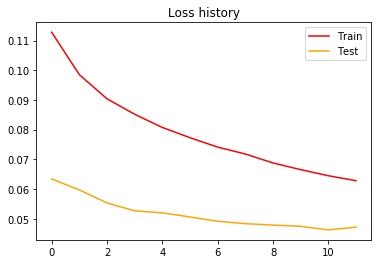

In [21]:
plt.plot(history[0],color='red',label='Train')
plt.plot(history[2],color='orange',label='Test')
plt.legend()
plt.plot()
plt.title("Loss history")

Text(0.5, 1.0, 'Training accuracy history')

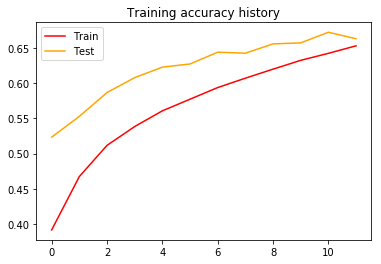

In [22]:
plt.plot(history[1],color='red',label='Train')
plt.plot(history[3],color='orange',label='Test')
plt.legend()
plt.plot()
plt.title("Training accuracy history")

### Accuracy rank

In [24]:
import sklearn.metrics

num_classes = len(dsets['train'].classes)
confu_matrix = np.zeros((num_classes,num_classes))

model_inception.eval()

for i, data in enumerate(dset_loaders['test'], 0):
    start_time = time.time()
                
    # get the inputs
    inputs, classes = data

    if use_gpu:
        inputs , classes = inputs.cuda(), classes.cuda()

    outputs = model_inception(inputs)

    _,preds = torch.max(outputs.data,1)
    
    confu_matrix += sklearn.metrics.confusion_matrix(classes.cpu(), preds.cpu(),labels=range(num_classes))
    
    print(i+1,"/",len(dset_loaders['test']),"batches processed",end="\r")
    
acc_dict2 = {}

for i in range(len(dsets['train'].classes)) :
    acc_dict2[dsets['train'].classes[i]] = float(confu_matrix[i][i])/np.sum(confu_matrix[i])
    
for key, value in sorted(acc_dict2.items(), key=lambda kv: kv[1],reverse = True):
    print("%s: %s" % (key, value))

deviled_eggs: 0.9650655021834061
spaghetti_bolognese: 0.8873239436619719
chicken_wings: 0.8767123287671232
lasagna: 0.8626609442060086
guacamole: 0.8508771929824561
mussels: 0.8461538461538461
french_onion_soup: 0.8295964125560538
baklava: 0.827433628318584
waffles: 0.8170212765957446
pulled_pork_sandwich: 0.8169642857142857
spaghetti_carbonara: 0.8119266055045872
churros: 0.8043478260869565
pancakes: 0.8034188034188035
creme_brulee: 0.8
caesar_salad: 0.7973568281938326
tiramisu: 0.7931034482758621
crab_cakes: 0.7918552036199095
panna_cotta: 0.7866666666666666
grilled_cheese_sandwich: 0.777292576419214
chocolate_cake: 0.7758620689655172
prime_rib: 0.7681818181818182
clam_chowder: 0.7678571428571429
takoyaki: 0.7668161434977578
risotto: 0.7627118644067796
spring_rolls: 0.7521739130434782
grilled_salmon: 0.7511111111111111
bruschetta: 0.7489177489177489
macarons: 0.7489177489177489
red_velvet_cake: 0.748898678414097
strawberry_shortcake: 0.7443946188340808
eggs_benedict: 0.73708920187793

### Continue training

In [13]:
model_inception.load_state_dict(torch.load('/home/foodlovers/FoodVisor/FoodVisor-TMM/trained_models/InceptionV3/model_current.pt'))

In [14]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer_incep = torch.optim.SGD(model_inception.parameters(),lr = lr, momentum=0.9)

In [15]:
history = train_model(train=True,validate=True,epochs = 12)

Epoch: 0 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 0 completed in 2517.07 seconds ! Loss: 0.0522 Acc: 0.7119
Val Loss: 0.0422 Val Acc: 0.7072 ...
Epoch: 1 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 1 completed in 2507.17 seconds ! Loss: 0.0487 Acc: 0.7296
Val Loss: 0.0417 Val Acc: 0.7113 ...
Epoch: 2 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 2 completed in 2506.81 seconds ! Loss: 0.0468 Acc: 0.7391
Val Loss: 0.0414 Val Acc: 0.7147 ...
Epoch: 3 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 3 completed in 2507.96 seconds ! Loss: 0.0457 Acc: 0.7436
Val Loss: 0.0415 Val Acc: 0.7158 ...
Epoch: 4 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 4 completed in 2509.24 seconds ! Loss: 0.0445 Acc: 0.7517
Val Loss: 0.0418 Val Acc: 0.7172 ...
Epoch: 5 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 5 completed in 2511.99 seconds ! Loss: 0.0435 Acc: 0.7574
Val Loss: 0.0417 Val Acc: 0.7171 ...
Epoch: 6 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 6 completed in 2512.18 seconds ! Loss: 0.0432 Acc: 0.7589
Val Loss: 0.0424 Val Acc: 0.7187 ...
Epoch: 7 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 7 completed in 2508.31 seconds ! Loss: 0.0423 Acc: 0.7639
Val Loss: 0.0419 Val Acc: 0.7181 ...
Epoch: 8 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 8 completed in 2507.85 seconds ! Loss: 0.0414 Acc: 0.7677
Val Loss: 0.0427 Val Acc: 0.7192 ...
Epoch: 9 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 9 completed in 2526.28 seconds ! Loss: 0.0407 Acc: 0.7741
Val Loss: 0.0429 Val Acc: 0.7205 ...
Epoch: 10 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 10 completed in 2526.21 seconds ! Loss: 0.0404 Acc: 0.7769
Val Loss: 0.0429 Val Acc: 0.7199 ...
Epoch: 11 / 12 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 11 completed in 2526.31 seconds ! Loss: 0.0396 Acc: 0.7816
Val Loss: 0.0432 Val Acc: 0.7217 ...


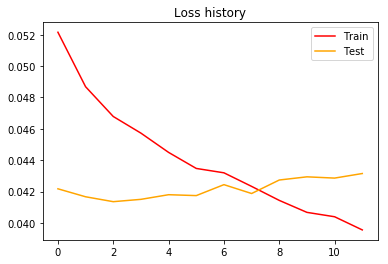

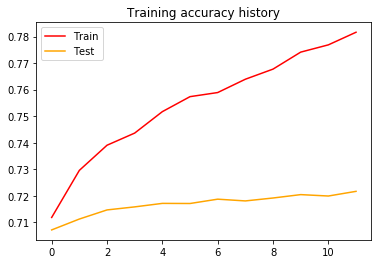

In [16]:
plt.figure(1)
plt.plot(history[0],color='red',label='Train')
plt.plot(history[2],color='orange',label='Test')
plt.legend()
plt.title("Loss history")

plt.figure(2)
plt.plot(history[1],color='red',label='Train')
plt.plot(history[3],color='orange',label='Test')
plt.legend()
plt.title("Training accuracy history")

plt.show()



In [1]:
# Plot history of 24 epochs
history = [[0.1128,0.0985,0.0904,0.0852,0.0807,0.0773,0.0741,0.0718,0.0688,0.0665,0.0645,0.0628,0.0522,0.0487,0.0468,0.0457,0.0445,0.0435,0.0432,0.0423,0.0414,0.0407,0.0404,0.0396],
 [0.3917,0.4674,0.5116,0.5383,0.5605,0.577,0.5936,0.6068,0.6197,0.6321,0.6421,0.6527,0.7119,0.7296,0.7391,0.7436,0.7517,0.7574,0.7589,0.7639,0.7677,0.7741,0.7769,0.7816],
 [0.0634,0.0597,0.0553,0.0526,0.052,0.0506,0.0491,0.0483,0.0478,0.0474,0.0462,0.0471,0.0422,0.0417,0.0414,0.0415,0.0418,0.0417,0.0424,0.0419,0.0427,0.0429,0.0429,0.0432],
 [0.5232,0.5527,0.5865,0.6076,0.6225,0.627,0.6437,0.6423,0.6555,0.6569,0.672,0.6628,0.7072,0.7113,0.7147,0.7158,0.7172,0.7171,0.7187,0.7181,0.7192,0.7205,0.7199, 0.7217]]

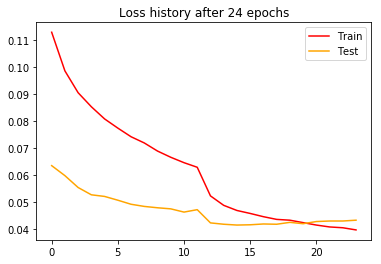

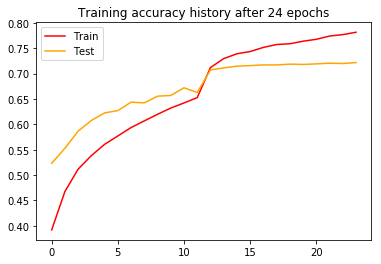

In [4]:
plt.figure(1)
plt.plot(history[0],color='red',label='Train')
plt.plot(history[2],color='orange',label='Test')
plt.legend()
plt.title("Loss history after 24 epochs")

plt.figure(2)
plt.plot(history[1],color='red',label='Train')
plt.plot(history[3],color='orange',label='Test')
plt.legend()
plt.title("Training accuracy history after 24 epochs")

plt.show()

In [17]:
import sklearn.metrics

num_classes = len(dsets['train'].classes)
confu_matrix = np.zeros((num_classes,num_classes))

model_inception.eval()

for i, data in enumerate(dset_loaders['test'], 0):
    start_time = time.time()
                
    # get the inputs
    inputs, classes = data

    if use_gpu:
        inputs , classes = inputs.cuda(), classes.cuda()

    outputs = model_inception(inputs)

    _,preds = torch.max(outputs.data,1)
    
    confu_matrix += sklearn.metrics.confusion_matrix(classes.cpu(), preds.cpu(),labels=range(num_classes))
    
    print(i+1,"/",len(dset_loaders['test']),"batches processed",end="\r")
    
acc_dict2 = {}

for i in range(len(dsets['train'].classes)) :
    acc_dict2[dsets['train'].classes[i]] = float(confu_matrix[i][i])/np.sum(confu_matrix[i])
    
for key, value in sorted(acc_dict2.items(), key=lambda kv: kv[1],reverse = True):
    print("%s: %s" % (key, value))

deviled_eggs: 0.9694323144104804
chicken_wings: 0.9041095890410958
pulled_pork_sandwich: 0.8883928571428571
spaghetti_bolognese: 0.8873239436619719
caesar_salad: 0.8810572687224669
spaghetti_carbonara: 0.8669724770642202
prime_rib: 0.8590909090909091
baklava: 0.8539823008849557
guacamole: 0.8464912280701754
waffles: 0.8425531914893617
french_onion_soup: 0.8385650224215246
lasagna: 0.8369098712446352
caprese_salad: 0.8318181818181818
strawberry_shortcake: 0.8295964125560538
beet_salad: 0.8258928571428571
greek_salad: 0.8251121076233184
mussels: 0.8247863247863247
churros: 0.8217391304347826
tiramisu: 0.8189655172413793
panna_cotta: 0.8177777777777778
spring_rolls: 0.8173913043478261
creme_brulee: 0.8133333333333334
eggs_benedict: 0.812206572769953
club_sandwich: 0.8090909090909091
grilled_cheese_sandwich: 0.8078602620087336
pancakes: 0.8034188034188035
paella: 0.7982456140350878
red_velvet_cake: 0.7973568281938326
pizza: 0.7914893617021277
grilled_salmon: 0.7911111111111111
fried_rice: 

## Comparasion after training 12 vs 24 epochs 

In [18]:
model_inception.load_state_dict(torch.load('/home/foodlovers/FoodVisor/FoodVisor-TMM/trained_models/InceptionV3/model_current.pt'))

In [19]:
confu_matrix_12 = np.zeros((num_classes,num_classes))

model_inception.eval()

for i, data in enumerate(dset_loaders['test'], 0):
    start_time = time.time()
                
    # get the inputs
    inputs, classes = data

    if use_gpu:
        inputs , classes = inputs.cuda(), classes.cuda()

    outputs = model_inception(inputs)

    _,preds = torch.max(outputs.data,1)
    
    confu_matrix_12 += sklearn.metrics.confusion_matrix(classes.cpu(), preds.cpu(),labels=range(num_classes))
    
    print(i+1,"/",len(dset_loaders['test']),"batches processed",end="\r")
    
acc_dict_12 = {}

for i in range(len(dsets['train'].classes)) :
    acc_dict_12[dsets['train'].classes[i]] = float(confu_matrix_12[i][i])/np.sum(confu_matrix[i])

In [22]:
for key, value in sorted(acc_dict_12.items(), key=lambda kv: kv[1],reverse = True):
    print("%s: %s" % (key, value))

deviled_eggs: 0.9650655021834061
spaghetti_bolognese: 0.8873239436619719
chicken_wings: 0.8767123287671232
lasagna: 0.8626609442060086
guacamole: 0.8508771929824561
mussels: 0.8461538461538461
french_onion_soup: 0.8295964125560538
baklava: 0.827433628318584
waffles: 0.8170212765957446
pulled_pork_sandwich: 0.8169642857142857
spaghetti_carbonara: 0.8119266055045872
churros: 0.8043478260869565
pancakes: 0.8034188034188035
creme_brulee: 0.8
caesar_salad: 0.7973568281938326
tiramisu: 0.7931034482758621
crab_cakes: 0.7918552036199095
panna_cotta: 0.7866666666666666
grilled_cheese_sandwich: 0.777292576419214
chocolate_cake: 0.7758620689655172
prime_rib: 0.7681818181818182
clam_chowder: 0.7678571428571429
takoyaki: 0.7668161434977578
risotto: 0.7627118644067796
spring_rolls: 0.7521739130434782
grilled_salmon: 0.7511111111111111
bruschetta: 0.7489177489177489
macarons: 0.7489177489177489
red_velvet_cake: 0.748898678414097
strawberry_shortcake: 0.7443946188340808
eggs_benedict: 0.73708920187793

In [23]:
acc_sorted_12vs24 = []
for key, value in sorted(acc_dict_12.items(), key=lambda kv: kv[1],reverse = True):
    acc_sorted_12vs24.append([key, value,acc_dict2[key]])
    print("%s: %s %s" % (key, value,acc_dict2[key]))

deviled_eggs: 0.9650655021834061 0.9694323144104804
spaghetti_bolognese: 0.8873239436619719 0.8873239436619719
chicken_wings: 0.8767123287671232 0.9041095890410958
lasagna: 0.8626609442060086 0.8369098712446352
guacamole: 0.8508771929824561 0.8464912280701754
mussels: 0.8461538461538461 0.8247863247863247
french_onion_soup: 0.8295964125560538 0.8385650224215246
baklava: 0.827433628318584 0.8539823008849557
waffles: 0.8170212765957446 0.8425531914893617
pulled_pork_sandwich: 0.8169642857142857 0.8883928571428571
spaghetti_carbonara: 0.8119266055045872 0.8669724770642202
churros: 0.8043478260869565 0.8217391304347826
pancakes: 0.8034188034188035 0.8034188034188035
creme_brulee: 0.8 0.8133333333333334
caesar_salad: 0.7973568281938326 0.8810572687224669
tiramisu: 0.7931034482758621 0.8189655172413793
crab_cakes: 0.7918552036199095 0.7737556561085973
panna_cotta: 0.7866666666666666 0.8177777777777778
grilled_cheese_sandwich: 0.777292576419214 0.8078602620087336
chocolate_cake: 0.77586206896

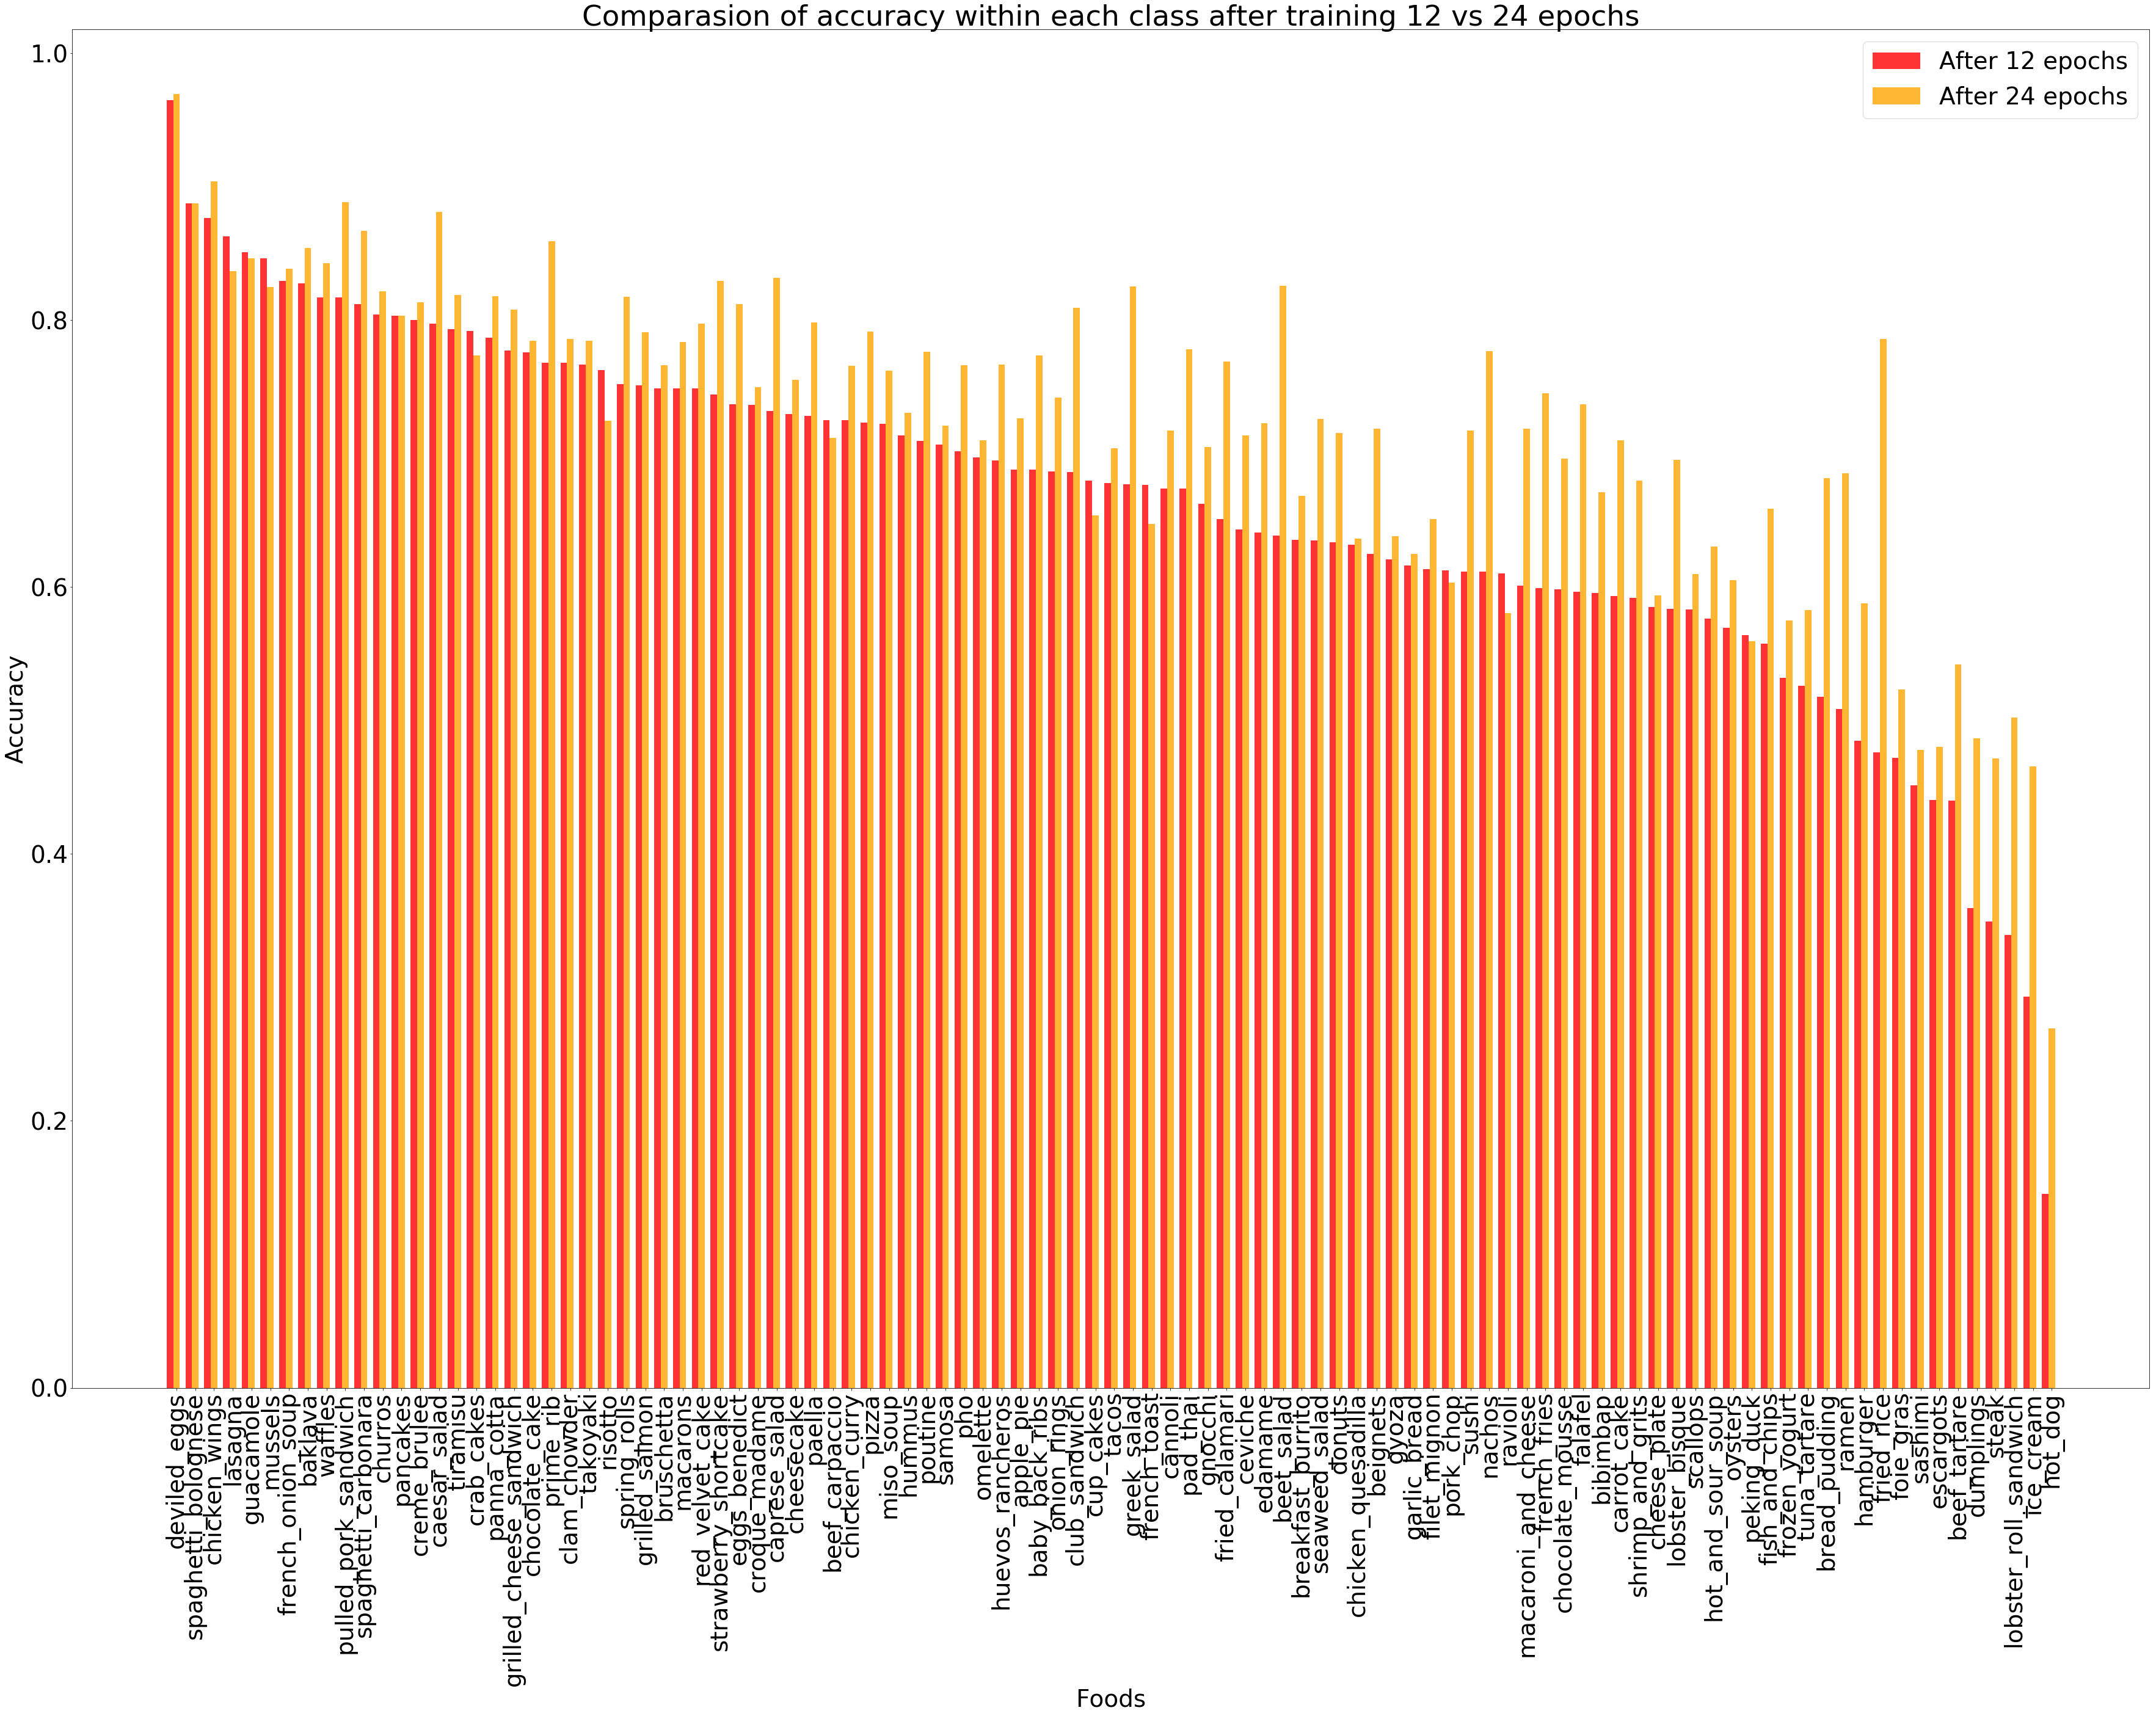

In [37]:
# create plot
# fig, ax = plt.subplots()

plt.rcParams.update({'font.size': 39})

fig=plt.figure(figsize=(50, 40))
index = np.arange(101)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, [x[1] for x in acc_sorted_12vs24], bar_width,
alpha=opacity,
color='r',
label='After 12 epochs')
 
rects2 = plt.bar(index + bar_width, [x[2] for x in acc_sorted_12vs24], bar_width,
alpha=opacity,
color='orange',
label='After 24 epochs')
 
plt.xlabel('Foods')
plt.ylabel('Accuracy')
plt.title('Comparasion of accuracy within each class after training 12 vs 24 epochs')
plt.xticks(index + bar_width, [x[0] for x in acc_sorted_12vs24],rotation='vertical')

plt.legend()
 
plt.tight_layout()
plt.show()

### Remove some non-food images

In [6]:
# Remove images in a temporary disk
temp_dir = "/mnt/images"

In [25]:
import os

text_file = open('/home/foodlovers/bad_images.txt', "r")

with open('/home/foodlovers/bad_images.txt', "r") as fp:  
    line = fp.readline()
    cnt = 1
    while line:
        path = temp_dir+"/"+"/".join(line.split("\\")[-3:])[:-1]
        os.system("sudo rm "+path)
        line = fp.readline()
        cnt += 1

In [7]:
dsets = {x: datasets.ImageFolder(os.path.join(temp_dir, x), data_transforms[x])
         for x in ['train', 'test']}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_sizes

{'train': 65980, 'test': 22716}

In [9]:
%%time
count_dict = {}
for i in range(len(dsets['train'])):
    print("{:d} / {:d}".format(i+1,len(dsets['train'])),end="\r")
    item = dsets['train'][i][1]
    if item not in count_dict:
        count_dict[item] = 1
    else :
        count_dict[item] += 1

/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

CPU times: user 56min 49s, sys: 24.1 s, total: 57min 13s
Wall time: 9min 33s


In [10]:
class_sample_counts = []

for i in range(101) :
    class_sample_counts.append(count_dict[i])
    
class_sample_counts

[675,
 631,
 665,
 654,
 661,
 650,
 635,
 652,
 676,
 639,
 690,
 676,
 671,
 648,
 683,
 674,
 619,
 685,
 663,
 648,
 654,
 671,
 658,
 669,
 663,
 654,
 659,
 665,
 664,
 600,
 682,
 660,
 675,
 658,
 637,
 530,
 674,
 630,
 592,
 627,
 632,
 665,
 711,
 625,
 682,
 652,
 668,
 693,
 657,
 683,
 673,
 677,
 660,
 683,
 583,
 573,
 657,
 697,
 654,
 693,
 561,
 472,
 693,
 606,
 670,
 692,
 669,
 684,
 637,
 653,
 685,
 682,
 697,
 662,
 577,
 640,
 692,
 675,
 623,
 645,
 662,
 674,
 683,
 592,
 706,
 631,
 640,
 682,
 618,
 645,
 629,
 648,
 682,
 676,
 658,
 677,
 695,
 545,
 683,
 611,
 693]

In [11]:
weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)

train_labels = [item[1] for item in dsets['train'].imgs]
sample_weights = weights[train_labels]

weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights, dset_sizes['train'])

sampler={'train': weighted_sampler, 'test': None}

/home/foodlovers/miniconda3/lib/python3.7/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


In [12]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=32,
                                                num_workers=6, sampler = sampler[x])
                for x in ['train', 'test']}

In [13]:
count = np.zeros(101)

for data in dset_loaders['train']:
    inputs_try,labels_try = data
    break
    
labels_try

tensor([ 89,  16,   5,  92,  43,  19,  34,  34,  40,  36,  27,  25,  28,  70,
         71,  25,  11,   7,  27, 100,  50,  84,  41,  10,  93,  94,  99,  17,
         44,  37,  79,  53])

In [14]:
model_inception = models.inception_v3(pretrained=True)

In [15]:
model_inception.fc = nn.Linear(2048, 101)
model_inception.AuxLogits.fc = nn.Linear(768, 101)
if use_gpu:
    model_inception = model_inception.cuda()

In [16]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer_incep = torch.optim.SGD(model_inception.parameters(),lr = lr, momentum=0.9)

In [17]:
model_inception.load_state_dict(torch.load('/home/foodlovers/FoodVisor/FoodVisor-TMM/trained_models/InceptionV3/model_current.pt'))

In [18]:
history = train_model(train=True,validate=True,epochs = 10)

Epoch: 0 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 0 completed in 2449.56 seconds ! Loss: 0.0506 Acc: 0.7181
Val Loss: 0.0422 Val Acc: 0.7087 ...
Epoch: 1 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 1 completed in 2452.97 seconds ! Loss: 0.0466 Acc: 0.7406
Val Loss: 0.0423 Val Acc: 0.7110 ...
Epoch: 2 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 2 completed in 2442.43 seconds ! Loss: 0.0451 Acc: 0.7487
Val Loss: 0.0418 Val Acc: 0.7159 ...
Epoch: 3 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 3 completed in 2436.32 seconds ! Loss: 0.0439 Acc: 0.7560
Val Loss: 0.0425 Val Acc: 0.7137 ...
Epoch: 4 / 10 ===============================================
Epoch 4 completed in 2439.93 seconds ! Loss: 0.0433 Acc: 0.7598
Val Loss: 0.0423 Val Acc: 0.7158 ...
Epoch: 5 / 10 ===============================================
Epoch 5 completed in 2452.15 seconds ! Loss: 0.0421 Acc: 0.7670
Val Loss: 0.0427 Val Acc: 0.7155 ...
Epoch: 6 / 10 ===============================================
Epoch 6 completed in 2451.73 seconds ! Loss: 0.0416 Acc: 0.7685
Val Loss: 0.0429 Val Acc: 0.7158 ...
Epoch: 7 / 10 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 7 completed in 2451.82 seconds ! Loss: 0.0404 Acc: 0.7759
Val Loss: 0.0433 Val Acc: 0.7155 ...
Epoch: 8 / 10 ===============================================
Epoch 8 completed in 2451.68 seconds ! Loss: 0.0405 Acc: 0.7736
Val Loss: 0.0434 Val Acc: 0.7159 ...
Epoch: 9 / 10 ===============================================
Epoch 9 completed in 2451.77 seconds ! Loss: 0.0397 Acc: 0.7773
Val Loss: 0.0438 Val Acc: 0.7157 ...


In [19]:
lr = 0.0001
optimizer_incep = torch.optim.SGD(model_inception.parameters(),lr = lr, momentum=0.9)

In [21]:
train_model(train=False,validate=True,epochs = 2)

Val Loss: 0.0431 Val Acc: 0.7171 ...


In [24]:
history_2 = train_model(train=True,validate=True,epochs = 2)

Epoch: 0 / 2 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 0 completed in 2449.44 seconds ! Loss: 0.0381 Acc: 0.7897
Val Loss: 0.0432 Val Acc: 0.7191 ...
Epoch: 1 / 2 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 1 completed in 2451.75 seconds ! Loss: 0.0380 Acc: 0.7888
Val Loss: 0.0429 Val Acc: 0.7187 ...


In [22]:
import sklearn.metrics

num_classes = len(dsets['train'].classes)
confu_matrix = np.zeros((num_classes,num_classes))

model_inception.eval()

for i, data in enumerate(dset_loaders['test'], 0):
    start_time = time.time()
                
    # get the inputs
    inputs, classes = data

    if use_gpu:
        inputs , classes = inputs.cuda(), classes.cuda()

    outputs = model_inception(inputs)

    _,preds = torch.max(outputs.data,1)
    
    confu_matrix += sklearn.metrics.confusion_matrix(classes.cpu(), preds.cpu(),labels=range(num_classes))
    
    print(i+1,"/",len(dset_loaders['test']),"batches processed",end="\r")
    
acc_dict2 = {}

for i in range(len(dsets['train'].classes)) :
    acc_dict2[dsets['train'].classes[i]] = float(confu_matrix[i][i])/np.sum(confu_matrix[i])
    
for key, value in sorted(acc_dict2.items(), key=lambda kv: kv[1],reverse = True):
    print("%s: %s" % (key, value))

deviled_eggs: 0.9606986899563319
chicken_wings: 0.8995433789954338
spaghetti_carbonara: 0.8899082568807339
spaghetti_bolognese: 0.8826291079812206
baklava: 0.8761061946902655
waffles: 0.8595744680851064
prime_rib: 0.8590909090909091
mussels: 0.8547008547008547
caesar_salad: 0.8546255506607929
pulled_pork_sandwich: 0.8526785714285714
strawberry_shortcake: 0.8430493273542601
guacamole: 0.8421052631578947
lasagna: 0.8283261802575107
french_onion_soup: 0.8251121076233184
panna_cotta: 0.8222222222222222
churros: 0.8217391304347826
greek_salad: 0.820627802690583
caprese_salad: 0.8181818181818182
grilled_cheese_sandwich: 0.8122270742358079
club_sandwich: 0.8090909090909091
spring_rolls: 0.808695652173913
pizza: 0.8042553191489362
pancakes: 0.7991452991452992
beet_salad: 0.7991071428571429
eggs_benedict: 0.7981220657276995
tiramisu: 0.7974137931034483
macarons: 0.7965367965367965
creme_brulee: 0.7955555555555556
grilled_salmon: 0.7955555555555556
pad_thai: 0.7913043478260869
paella: 0.78947368